<a href="https://colab.research.google.com/github/fpinell/hands_on_python_for_ds/blob/main/notebooks/phd/test_and_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on Python for Data Science

### PhD IMT School for advanced studies Lucca


#### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2021/2022<br/>
June, 28 2022


### What I'll do

- Try to help you during the test [**DONE**]
- Load your uploaded files and trying to evaluate your solution
- Explore a possible solution :-)  

### Load your uploaded files and trying to evaluate your solution

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
df_train = pd.read_csv('/content/drive/Shareddrives/phd_hands_on/data/titanic/train.csv')

In [4]:
# df_train.columns

In [5]:
df_train[['PassengerId','Survived']].to_csv('/content/drive/Shareddrives/phd_hands_on/test/fabio.csv',index=False,sep=',')

In [6]:
directory = '/content/drive/Shareddrives/phd_hands_on/test/'

In [7]:
files = glob(directory+ '*.csv')

In [8]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix

results = {
    'name':[],
    'precision':[],
    'recall':[],
    'accuracy':[]
}

for f in files:
  
  try:
  
    student_name = f.split('/')[-1].split('.csv')[0]
    solution = pd.read_csv(f)
    df_merge = pd.merge(solution,df_train[['PassengerId']],on='PassengerId')

    precision = precision_score(df_train['Survived'],df_merge['Survived'])
    recall = recall_score(df_train['Survived'],df_merge['Survived'])
    accuracy = accuracy_score(df_train['Survived'],df_merge['Survived'])
    
    print('{} got {} precision'.format(student_name,precision))
    print('{} got {} recall'.format(student_name,recall))
    print('{} got {} accuracy'.format(student_name,accuracy))

    results['name'].append(student_name)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['accuracy'].append(accuracy)
  except Exception as e: 
    print("Failed reading the file {}".format(f))
    print("with exception {}".format(e))

df_results = pd.DataFrame(results)

fabio_2 got 1.0 precision
fabio_2 got 1.0 recall
fabio_2 got 1.0 accuracy
fabio got 1.0 precision
fabio got 1.0 recall
fabio got 1.0 accuracy


In [52]:
df_results.sort_values(by='accuracy',ascending=False)

,name,precision,recall,accuracy
0,fabio_2,1.0,1.0,1.0
1,fabio,1.0,1.0,1.0


# Possible solution

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import recall_score,precision_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier

In [11]:
df_train = pd.read_csv('/content/drive/Shareddrives/phd_hands_on/data/titanic/train.csv')

In [12]:
df_train.shape

(891, 12)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Okay, the Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

Moreover, the **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

In [15]:

df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
df_train = df_train[['PassengerId','Survived','Pclass', 
                     'Sex', 'Age', 'SibSp','Parch',
                     'Fare', 'Embarked']].copy()

In [17]:
attributes = ['Pclass','Age','SibSp','Parch','Fare']

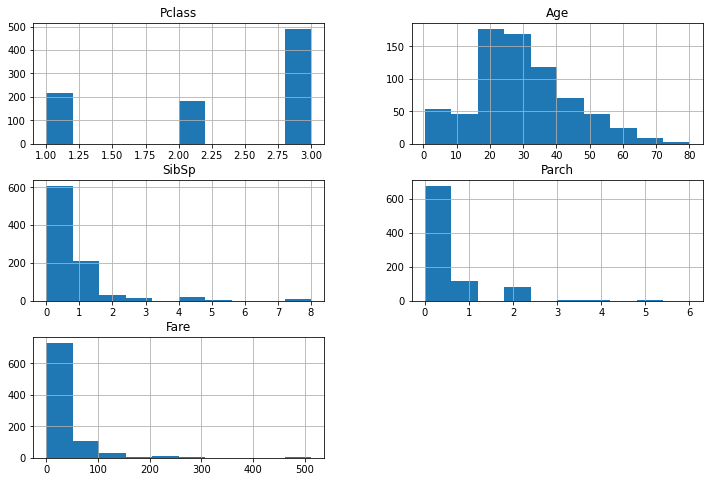

In [18]:

_ = df_train[attributes].hist(figsize=(12, 8))

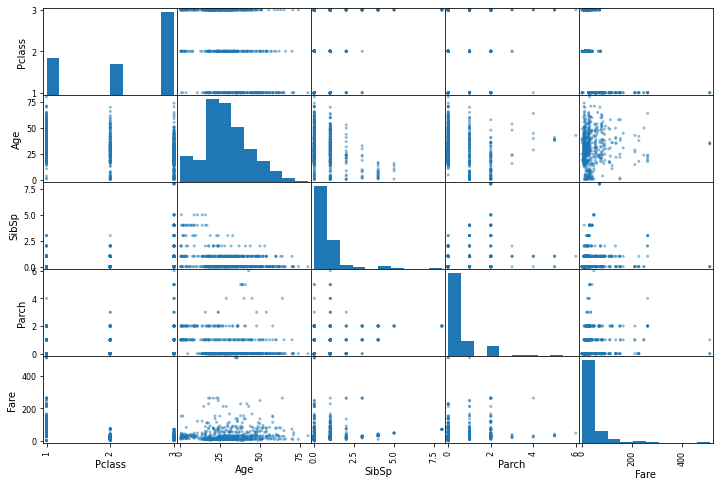

In [19]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(df_train[attributes], figsize=(12, 8))

In [20]:
df_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [21]:

df_train.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,644
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN


In [22]:
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [23]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Equivalent ```python SimpleImputer(strategy='most_frequent') ```

In [24]:

SimpleImputer(strategy='most_frequent')

SimpleImputer(strategy='most_frequent')

In [25]:

cat_colums = ["Pclass", "Sex", "Embarked"]
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])


In [26]:
num_columns = ["Age", "SibSp", "Parch", "Fare"]
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

In [27]:

column_transform = ColumnTransformer([
    ('cat',cat_pipeline,cat_colums),
    ('num',num_pipeline,num_columns)
    ],
    remainder='passthrough'
)

In [28]:
X = df_train.iloc[:,2:].copy()
y = df_train.iloc[:,1].copy()

In [29]:
X.columns


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [30]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [31]:
column_transform.fit_transform(X).shape

(891, 12)

In [32]:
pipeline = Pipeline(steps=[('preprocessor',column_transform),('classifier',RandomForestClassifier(random_state=42))])
params = [{'preprocessor': [column_transform],
          'classifier': [GradientBoostingClassifier(random_state=42),RandomForestClassifier(random_state=42),XGBClassifier(random_state=42)],
           'preprocessor__num__scaler': ['passthrough',MinMaxScaler(),StandardScaler()]
        }]

gs = GridSearchCV(pipeline,params , verbose=5, n_jobs=5,scoring='accuracy', cv=5).fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [51]:

GridSearchCV(pipeline,params , verbose=5, n_jobs=5,scoring='accuracy', cv=5).get_params()

{'cv': 5, 'error_score': nan, 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    MostFrequentImputer()),
                                                                   ('cat_encoder',
                                                                    OneHotEncoder(sparse=False))]),
                                                   ['Pclass', 'Sex',
                                                    'Embarked']),
                                                  ('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler'

In [33]:
gs.get_params()

{'cv': 5, 'error_score': nan, 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    MostFrequentImputer()),
                                                                   ('cat_encoder',
                                                                    OneHotEncoder(sparse=False))]),
                                                   ['Pclass', 'Sex',
                                                    'Embarked']),
                                                  ('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler'

In [34]:
df_gs = pd.DataFrame(gs.cv_results_)

In [35]:
df_gs.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_preprocessor,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.764525,0.130158,0.039924,0.015687,GradientBoostingClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",StandardScaler(),{'classifier': GradientBoostingClassifier(rand...,0.821229,0.808989,0.853933,0.803371,0.853933,0.828291,0.021718,1
0,0.549969,0.021924,0.030204,0.004601,GradientBoostingClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",passthrough,{'classifier': GradientBoostingClassifier(rand...,0.815642,0.808989,0.853933,0.803371,0.853933,0.827173,0.022192,2
1,0.561742,0.028726,0.032973,0.004950,GradientBoostingClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",MinMaxScaler(),{'classifier': GradientBoostingClassifier(rand...,0.815642,0.808989,0.853933,0.803371,0.853933,0.827173,0.022192,2
6,0.319805,0.062938,0.028713,0.004516,XGBClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",passthrough,"{'classifier': XGBClassifier(random_state=42),...",0.804469,0.808989,0.814607,0.808989,0.848315,0.817074,0.015948,4
7,0.272729,0.030064,0.026640,0.008063,XGBClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",MinMaxScaler(),"{'classifier': XGBClassifier(random_state=42),...",0.804469,0.808989,0.814607,0.808989,0.848315,0.817074,0.015948,4
8,0.248668,0.045946,0.026629,0.011533,XGBClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",StandardScaler(),"{'classifier': XGBClassifier(random_state=42),...",0.804469,0.808989,0.814607,0.808989,0.848315,0.817074,0.015948,4
3,1.327925,0.102426,0.115135,0.032461,RandomForestClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",passthrough,{'classifier': RandomForestClassifier(random_s...,0.793296,0.808989,0.848315,0.780899,0.825843,0.811468,0.023812,7
4,0.831008,0.039778,0.081208,0.009889,RandomForestClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",MinMaxScaler(),{'classifier': RandomForestClassifier(random_s...,0.793296,0.808989,0.848315,0.780899,0.825843,0.811468,0.023812,7
5,0.792638,0.047263,0.078316,0.038210,RandomForestClassifier(random_state=42),"ColumnTransformer(remainder='passthrough',\n ...",StandardScaler(),{'classifier': RandomForestClassifier(random_s...,0.793296,0.808989,0.848315,0.780899,0.825843,0.811468,0.023812,7


In [36]:
best_classifier = gs.best_estimator_ 

In [37]:
best_classifier.named_steps['preprocessor'].named_transformers_

{'cat': Pipeline(steps=[('imputer', MostFrequentImputer()),
                 ('cat_encoder', OneHotEncoder(sparse=False))]),
 'num': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler())])}

In [38]:
best_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   MostFrequentImputer()),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                     

In [39]:
best_classifier = gs.best_estimator_ 
one_hot_columns_trans = list(best_classifier.named_steps['preprocessor'].named_transformers_['cat'][1].get_feature_names_out())


In [40]:
one_hot_columns_trans + num_columns

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Age',
 'SibSp',
 'Parch',
 'Fare']

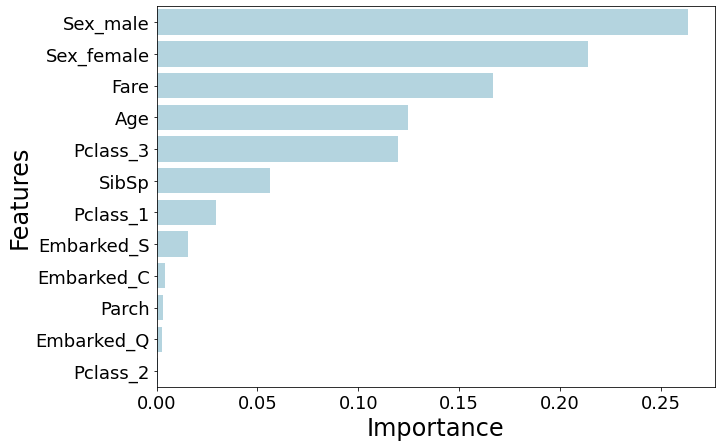

In [41]:
feature_importances = gs.best_estimator_['classifier'].feature_importances_
feature_importances

attributes = one_hot_columns_trans + num_columns


feature_importance_map = []
for imp, feat in sorted(zip(feature_importances, attributes), reverse=True):
    feature_importance_map.append([feat,imp])

df_importance = pd.DataFrame(feature_importance_map,columns=['Feature_name','importance'])

df_importance = df_importance.sort_values('importance',ascending=False)[:25].copy()

plt.figure(figsize=(10,7))
ax = sns.barplot(y='Feature_name',x='importance',data=df_importance,color='lightblue')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Importance',fontsize=24)
plt.ylabel('Features',fontsize=24)
plt.show()

In [50]:
gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   MostFrequentImputer()),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                     

In [44]:
predictions = gs.best_estimator_.predict(X)

In [46]:

df_train['predictions'] = predictions

In [47]:
accuracy_score(df_train['Survived'],df_train['predictions'])

0.9034792368125701